# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Os dados foram fornecidos pela startup brasileira Loggi, que realiza entregas em diversas cidades do Brasil. A empresa trabalha no contexto <i>Last-Mile</i>, ou seja, a etapa final da entrega, realizada dentro do município, do centro de distribuição até a residência do cliente.

Dos diversos problemas que poderão ser apontados na análise, podemos citar otimização de rotas de entrega afim de minimizar a distância entre os centros de distribuição até o objetivo, otimização na distribuição das cargas nos veículos e consumo de combustível.

## 2\. Pacotes e bibliotecas

In [ ]:
# importação das bibliotecas
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy
import geopandas

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [ ]:
!pip install geopandas

## 3\. Exploração de dados

In [ ]:
# coleta e exploração dos dados
!wget -q 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json' -O deliveries.json

data = json.load(open('deliveries.json', 'r', encoding='utf8'))

data[0].keys()

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])

Os dados foram baixados do GitHub. Faço a leitura e o carrego em uma variável. Para entender melhor a composição das chaves do arquivo json, chamei o método keys() do primeiro registro, que me retorna uma lista com os nomes das chaves.

```json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      }
    ]
  }
]
```

A composição do arquivo permite se ter uma noção de como os dados estão organizados.

In [ ]:
df = pd.DataFrame(data)
df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Carregando o arquivo em um dataframe e visualizando os primeiros registros, nota-se que as colunas **origin** e **deliveries** são listas de dicionários. Esses dados terão de ser tratados e transformados em colunas do dataframe.

In [ ]:
# normalizando (flatten) dados nested (aninhados)
origin_normalized = pd.json_normalize(df['origin'])
origin_normalized.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


Utilizando o método json_normalize() do Pandas, a coluna origin é transformada em um dataframe de duas colunas, separando latitude e longitude.

In [ ]:
# copia do df original
deliveries_df = df.copy()

deliveries_df = pd.merge(deliveries_df, origin_normalized, how='inner', left_index=True, right_index=True)

deliveries_df.drop('origin', axis=1, inplace=True)
deliveries_df.rename(columns={'lng': 'hub_lng', 'lat': 'hub_lat'}, inplace=True)
deliveries_df.head()

,name,region,vehicle_capacity,deliveries,hub_lng,hub_lat
0,cvrp-2-df-33,df-2,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


Antes de tudo fiz uma cópia do dataframe original para preservá-lo e não precisar recarregá-lo por algum motivo.

Após, é feito um merge do dataframe original e o com os dados de latitude e longitude normalizados, relacionados pelos índices. A coluna original origin é excluída por não se fazer mais necessário.

In [ ]:
# explode a coluna deliveries
deliveries_exploded = deliveries_df[['deliveries']].explode('deliveries')

deliveries_normalized = pd.concat([
    pd.DataFrame(deliveries_exploded.deliveries.apply(lambda x: x['size'])) \
    .rename(columns={'deliveries': 'delivery_size'}),
    pd.DataFrame(deliveries_exploded.deliveries.apply(lambda x: x['point']['lng'])) \
    .rename(columns={'deliveries': 'delivery_lng'}),
    pd.DataFrame(deliveries_exploded.deliveries.apply(lambda x: x['point']['lat'])) \
    .rename(columns={'deliveries': 'delivery_lat'})
], axis=1)

deliveries_normalized.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


Com a coluna deliveries é mais complexo, uma vez que o nível de profundidade é um pouco diferente da coluna origin. Com o método explode() do Pandas, os dados são separados em linhas. São criados três dataframes para os dados size, longitude e latitude das entregas e concatenados. Após esse processo, cada linha foi tratada e temos um dataframe com os dados das entregas.

In [ ]:
deliveries_df.drop('deliveries', axis=1, inplace=True)
deliveries_df = pd.merge(deliveries_df, deliveries_normalized, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,vehicle_capacity,hub_lng,hub_lat,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,7,-48.114898,-15.858055


Após o tratamento da coluna deliveries, ela é elimindada e os dataframes são unidos pelo índice. Agora, cada hub, que é o centro de ditribuição das entregas, está relacionado não só com os veículos mas também com as entregas.

In [ ]:
len(deliveries_df)

636149

O dataframe ficou bem grande devido a "explosão" da coluna deliveries, que antes era um lista de dicionários das entregas.

In [ ]:
deliveries_df.to_csv('deliveries.csv', sep=';')

Salvei o dataframe em um csv para não precisar refazer todo o tratamento, se for necessário, bastando apenas carregar o csv.

###**Análise Exploratória dos Dados**

In [ ]:
linhas, colunas = deliveries_df.shape
print(f'\nTamanho do DataFrame\nLinhas: {linhas}\nColunas: {colunas}\n')


Tamanho do DataFrame
Linhas: 636149
Colunas: 8



Como dito antes, o dataframe ficou bem grande após a transformação da coluna deliveries em linhas, relacionando cada entrega a seu hub.

In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   vehicle_capacity  636149 non-null  int64  
 3   hub_lng           636149 non-null  float64
 4   hub_lat           636149 non-null  float64
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


Agora é possível analisar os dados. Não existem dado nulos. Basicamente, o dataframe é composto por dados float e int, onde apenas name e region são strings.

In [ ]:
# dados categoricos
deliveries_df.select_dtypes('object').describe().T

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


Separando os dados categóricos, vemos que a contagem de linhas bate, onde a coluna name possui 199 dados únicos, assim como no dataframe original, antes de tratarmos a coluna deliveries. São 3 hubs ao todo. O hub cvrp-1-df-87	é o mais frequente, assim como a região df-1, que também concentra a maioria das entregas.

In [ ]:
# dados numericos
deliveries_df.drop(['name', 'region'], axis=1).select_dtypes('int64').describe().T

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


Separamos aqui apenas os dados do veículo e o tamanho da entrega, uma vez que não faz muito sentido obter estatísticas de dados de geo-localização, como desvio padrão, por exemplo.

Todos os veículos possuem capacidade igual a 180. O desvio padrão igual a 0 confirma essa estatística.

No tamanho da entrega, vemos que a média e mediana não estão muito distantes, nos indicando que pode haver uma distribuição simétrica dos dados. O desvio padrão está em 2.87, indicando que capacidade do veículo pode ter, em média, entre 2.6 e 8.3. Vemos também que não existem cargas menores que 10.

In [ ]:
deliveries_df.isnull().sum()

name                0
region              0
vehicle_capacity    0
hub_lng             0
hub_lat             0
delivery_size       0
delivery_lng        0
delivery_lat        0
dtype: int64

Somente para validar, não existe nenhum dado nulo em nenhuma coluna.

## 4\. Manipulação

### Hubs

In [ ]:
hubs = deliveries_df[['region', 'hub_lng', 'hub_lat']]
hubs = hubs.drop_duplicates().sort_values(by='region').reset_index(drop=True)
hubs.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Seleção das colunas de interesse e remoção de duplicadas.

In [ ]:
gloc = Nominatim(user_agent='psartoro')
gcod = RateLimiter(gloc.reverse, min_delay_seconds=1)

In [ ]:
hubs['coordinates'] = hubs.hub_lat.astype(str) + ', ' + hubs.hub_lng.astype(str)
hubs['geodata'] = hubs.coordinates.apply(gcod)
hubs.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíl..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


Criamos uma nova coluna com as coordenadas de cada hub. Dessa forma, podemos aplicar a consulta e trazer os dados geográficos de cada hub.

In [ ]:
hubs_geodata = pd.json_normalize(hubs.geodata.apply(lambda x: x.raw))
hubs_geodata.head()

,place_id,licence,osm_type,osm_id,lat,lon,display_name,boundingbox,address.amenity,address.road,address.residential,address.suburb,address.town,address.municipality,address.county,address.state_district,address.state,address.region,address.postcode,address.country,address.country_code,address.building,address.neighbourhood,address.city,address.shop,address.house_number
0,69392732,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6456379935,-15.656819,-47.8019514,"Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho...","[-15.656869, -15.656769, -47.8020014, -47.8019...",Clinica dos Olhos,Rua 7,Quadra 2,Sobradinho,Sobradinho,Região Geográfica Imediata do Distrito Federal,Região Integrada de Desenvolvimento do Distrit...,Região Geográfica Intermediária do Distrito Fe...,Distrito Federal,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,134245547,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,140908717,-15.80443735,-47.893155456691616,"Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíli...","[-15.805071, -15.8038038, -47.8937468, -47.892...",NaN,W1 Sul,NaN,Asa Sul,NaN,Região Geográfica Imediata do Distrito Federal,Região Integrada de Desenvolvimento do Distrit...,Região Geográfica Intermediária do Distrito Fe...,Distrito Federal,Região Centro-Oeste,70342-010,Brasil,br,Bloco B / F,SQS 103,Brasília,NaN,NaN
2,68616994,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,"Armazém do Bolo, lote 4/8, CSB 4/5, Taguatinga...","[-15.8384871, -15.8383871, -48.0553417, -48.05...",NaN,CSB 4/5,NaN,NaN,NaN,Região Geográfica Imediata do Distrito Federal,Região Integrada de Desenvolvimento do Distrit...,Região Geográfica Intermediária do Distrito Fe...,Distrito Federal,Região Centro-Oeste,72015030,Brasil,br,NaN,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [ ]:
for i in range(len(hubs_geodata['display_name'])):
  hubs_geodata.loc[i, 'hub_city'] = hubs_geodata['display_name'][i].split(',')[3]

hubs_geodata = hubs_geodata.loc[:, ['address.suburb', 'hub_city']]
hubs_geodata.rename(columns={'address.suburb': 'hub_suburb'}, inplace=True)
hubs_geodata['hub_suburb'] = np.where(hubs_geodata.hub_suburb.notna(), hubs_geodata.hub_suburb, hubs_geodata.hub_city)

hubs_geodata

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Asa Sul
2,Taguatinga,Taguatinga


Adotei uma abordagem diferente ao notar que a coluna `display_name`, nese caso, contém os dados necessários para preencher a informação de interesse, que é `bairro` e `cidade` do hub.

In [ ]:
hubs = pd.merge(hubs, hubs_geodata, left_index=True, right_index=True)
hubs = hubs[['region', 'hub_suburb', 'hub_city']]

deliveries_df = pd.merge(deliveries_df, hubs, how='inner', on='region')

deliveries_df.head()

,name,region,vehicle_capacity,hub_lng,hub_lat,delivery_size,delivery_lng,delivery_lat,hub_suburb,hub_city
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,9,-48.116189,-15.848929,Taguatinga,Taguatinga
1,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118195,-15.850772,Taguatinga,Taguatinga
2,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,1,-48.112483,-15.847871,Taguatinga,Taguatinga
3,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118023,-15.846471,Taguatinga,Taguatinga
4,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,7,-48.114898,-15.858055,Taguatinga,Taguatinga


Por fim, unimos os dados geográficos de cada hub ao dataframe original.

In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   vehicle_capacity  636149 non-null  int64  
 3   hub_lng           636149 non-null  float64
 4   hub_lat           636149 non-null  float64
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
 8   hub_suburb        636149 non-null  object 
 9   hub_city          636149 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 53.4+ MB


Com a adição dos novos dados ao dataframe original, o tamanho se manteve e não há nenhum dado nulo.

### Deliveries

Devido ao tamanho da informação e o tempo que levaria para consultar cada entrega, os dados foram coletados do link abaixo.

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [ ]:
deliveries_geo_df = pd.read_csv('deliveries-geodata.csv')
deliveries_geo_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
deliveries_geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   delivery_lng     636149 non-null  float64
 1   delivery_lat     636149 non-null  float64
 2   delivery_city    634447 non-null  object 
 3   delivery_suburb  476264 non-null  object 
dtypes: float64(2), object(2)
memory usage: 19.4+ MB


O novo dataframe possui muitos dados nulos das cidades e bairros.

In [ ]:
deliveries_geo_df.isnull().sum()

delivery_lng            0
delivery_lat            0
delivery_city        1702
delivery_suburb    159885
dtype: int64

Não possui dados de mais da metade dos bairros e algumas cidades.

In [ ]:
deliveries_df = pd.merge(
    deliveries_df, 
    deliveries_geo_df[["delivery_city", "delivery_suburb"]], 
    how="inner", 
    left_index=True, 
    right_index=True
    )

deliveries_df.head()

,name,region,vehicle_capacity,hub_lng,hub_lat,delivery_size,delivery_lng,delivery_lat,hub_suburb,hub_city,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,9,-48.116189,-15.848929,Taguatinga,Taguatinga,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118195,-15.850772,Taguatinga,Taguatinga,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,1,-48.112483,-15.847871,Taguatinga,Taguatinga,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118023,-15.846471,Taguatinga,Taguatinga,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,7,-48.114898,-15.858055,Taguatinga,Taguatinga,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   vehicle_capacity  636149 non-null  int64  
 3   hub_lng           636149 non-null  float64
 4   hub_lat           636149 non-null  float64
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
 8   hub_suburb        636149 non-null  object 
 9   hub_city          636149 non-null  object 
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 83.1+ MB


Após o merge, o dataframe original aumentou de tamanho na memória e agora, como visto antes, temos dados nulos.

### Proporção de dados nulos

In [ ]:
city_isna = round((deliveries_df.delivery_city.isnull().sum() / len(deliveries_df)) * 100, 2)
suburb_isna = round((deliveries_df.delivery_suburb.isnull().sum() / len(deliveries_df)) * 100, 2)
print('Proporção de dados nulos')
print(f'delivery_city possui {city_isna}% dos dados nulos\ndelivery_suburb possui {suburb_isna}% dos dados nulos')

Proporção de dados nulos
delivery_city possui 0.27% dos dados nulos
delivery_suburb possui 25.13% dos dados nulos


Mais de 25% dos dados de bairro estão faltando. Tem de se avaliar se essa informação será relevante para a análise.

In [ ]:
round((deliveries_df.delivery_city.value_counts() / len(deliveries_df)) * 100, 2).head(10)

Brasília                23.42
Taguatinga               7.16
Sudoeste / Octogonal     6.95
Ceilândia                5.97
Águas Claras             5.83
Guará                    5.56
Lago Sul                 4.56
Sobradinho               4.54
Lago Norte               4.08
Gama                     3.49
Name: delivery_city, dtype: float64

In [139]:
round((deliveries_df.delivery_suburb.value_counts() / len(deliveries_df)) * 100, 2).head(10)

Brasília            8.46
Asa Norte           7.66
Taguatinga          6.34
Asa Sul             5.93
Águas Claras        5.66
Guará               5.56
Samambaia           2.65
Sobradinho          1.81
Recanto das Emas    1.50
P Sul               1.28
Name: delivery_suburb, dtype: float64

Tanto em cidades quanto nos bairros,existem muitos dados agregados em Brasília, o que pode confundir, visto que não existe, dentro do contexto, cidade nem bairro denominados como Brasília, e sim regiões do Distrito Federal.

## 5\. Visualização

In [ ]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [ ]:
mapa = geopandas.read_file('distrito-federal.shp')
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [ ]:
hubs = deliveries_df[['region', 'hub_lng', 'hub_lat']].drop_duplicates().reset_index(drop=True)
geo_hubs = geopandas.GeoDataFrame(hubs, geometry=geopandas.points_from_xy(hubs.hub_lng, hubs.hub_lat))
geo_hubs.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [ ]:
geo_deliveries = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df.delivery_lng, deliveries_df.delivery_lat))
geo_deliveries.head()

,name,region,vehicle_capacity,hub_lng,hub_lat,delivery_size,delivery_lng,delivery_lat,hub_suburb,hub_city,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,9,-48.116189,-15.848929,Taguatinga,Taguatinga,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118195,-15.850772,Taguatinga,Taguatinga,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,1,-48.112483,-15.847871,Taguatinga,Taguatinga,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,2,-48.118023,-15.846471,Taguatinga,Taguatinga,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,180,-48.054989,-15.838145,7,-48.114898,-15.858055,Taguatinga,Taguatinga,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


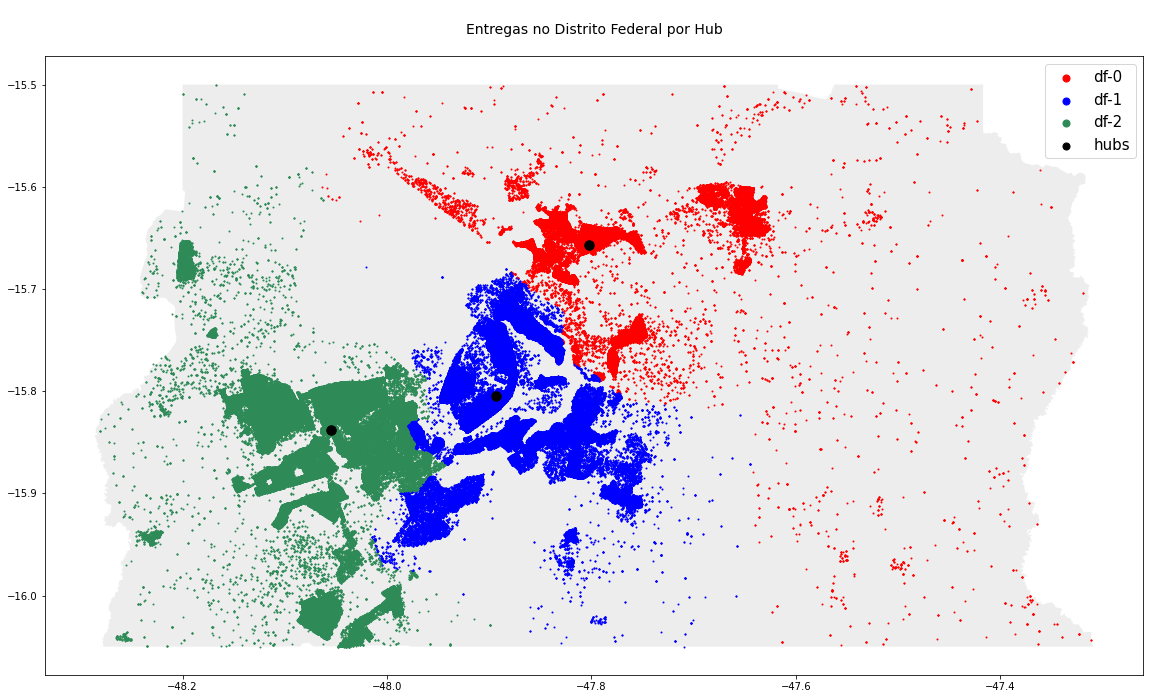

In [142]:
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

geo_deliveries.query("region == 'df-0'").plot(ax=ax, markersize=1, color='red', label='df-0')
geo_deliveries.query("region == 'df-1'").plot(ax=ax, markersize=1, color='blue', label='df-1')
geo_deliveries.query("region == 'df-2'").plot(ax=ax, markersize=1, color='seagreen', label='df-2')

geo_hubs.plot(ax=ax, markersize=90, marker='o', color='#000', label='hubs')


plt.title('\nEntregas no Distrito Federal por Hub\n', fontsize=14)
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

Usando o pacote `geopandas` construímos o mapa do DF e marcamos as coordenadas de cada hub, pintando sua área de cobertura de entrega.

Região df-0 tem uma cobertura mais esparçada, enquanto os outros tem entregas mais concentradas. Talvez, nessa área, se concentre a zona rural do DF.

Região df1 tem suas entregas mais concentradas, muito por atender o centro de Brasília.

Região df-2 tem tanto entregas mais concentradas, quanto mais espalhadas.

As regiões df-1 e df-2 possuem entregas que se confundem, "invadinho" o território um do outro. 

In [119]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: 'percent'}, inplace=True)
data

,region,vehicle_capacity,percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


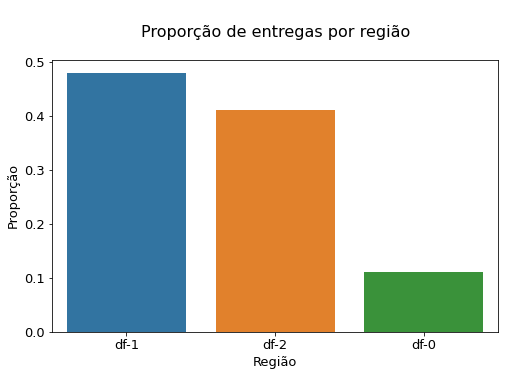

In [141]:
plt.figure(figsize=(8, 5))

sns.barplot(data=data, x='region', y='percent')

plt.title('\nProporção de entregas por região\n', size=16)
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel('Região', fontsize=13)
plt.ylabel('Proporção', fontsize=13)

plt.show()

As entregas estão mais concentradas nas regiões 1 e 2. Tendo os veículos a mesma capacidade, poderia haver uma melhor distribuição de veículos nessas regiões, e deslocar uma frota menor para região 0. Porém, sendo a região 0 mais espalhada, talvez os verículos fiquem mais tempo rodando, sendo necessário mantê-los.